# Optimization Methods MA060002
## Homework 5
By: Darío Slaifstein, PhD-2.

In [1]:
import pyomo
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from scipy.optimize import minimize
from scipy.sparse import csgraph
from pyomo.environ import *

### 1. Signal processing
First we will create 3 signals and add them Gaussian noise on top. The first one is a sawtooth, the second a quadratic function and the third one a Pulse Width Modulated signal typical in electronics applications.

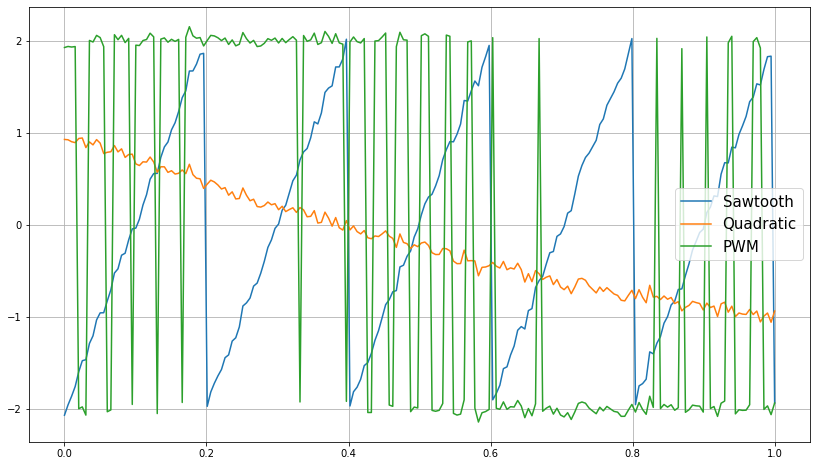

In [2]:
sigma = 0.05 # variance of input noise
N = 200 # number of data points
alpha = 2 # input scaling
t = np.linspace(0,1,N)

# signals
# sawtooth
xSaw = alpha * sp.signal.sawtooth(2 * np.pi * 5 * t);
# quadratic measurement
xQuad = t**2 - 3*t + 1
# PWM
sine = np.sin(2 * np.pi * t)
xPWM = alpha * sp.signal.square(2 * np.pi * 30 * t, duty=(sine + 1)/2)

# error
noise = np.random.normal(0,sigma,N)

# noisy signals
ySaw = xSaw + noise
yQuad = xQuad + noise
yPWM = xPWM + noise

# 
plt.figure(figsize=(14,8))
plt.plot(t, ySaw,label='Sawtooth')
plt.plot(t, yQuad,label='Quadratic')
plt.plot(t, yPWM,label='PWM')
plt.grid(); plt.legend(fontsize=15)

Now the recovery function will try to filter the noise with different filtering/penalization functions.

In [3]:
# The objective Function to minimize (least-squares regression)
# Penalization functions
def penalty1(y):
    d1 = []
    for i in range(len(y)-1):
        d1.append(y[i]-y[i+1])
    return np.linalg.norm(d1, ord=2)

def penalty2(y):
    d1 = []
    for i in range(len(y)-1):
        d1.append(y[i]-y[i+1])
    return np.linalg.norm(d1, ord=1)

def penalty3(y):
    d1 = []
    for i in range(len(y)-2):
        d1.append(y[i]-2*y[i+1]+y[i+2])
    return np.linalg.norm(d1, ord=1)

# Residuals
def residuals(y,x):
    d = x - y
    return np.linalg.norm(d, ord=2)

# Objective functions
def obj1(y,x,gamma):
    p1 = penalty1(y)
    p2 = residuals(y,x)
    return p2+gamma*p1

def obj2(y,x,gamma):
    p1 = penalty2(y)
    p2 = residuals(y,x)
    return p2+gamma*p1

def obj3(y,x,gamma):
    p1 = penalty3(y)
    p2 = residuals(y,x)
    return p2+gamma*p1

For every true $x$ we have a noisy $y$ which we can filter to obtain an estimate $x_e$

In [4]:
# Sawtooth estimate
gamma=[5,5,5]
estSaw1 = sp.optimize.minimize(lambda y: obj1(y,xSaw,gamma[0]),ySaw,method='Powell')
estSaw2 = sp.optimize.minimize(lambda y: obj2(y,xSaw,gamma[1]),ySaw,method='Powell')
estSaw3 = sp.optimize.minimize(lambda y: obj3(y,xSaw,gamma[2]),ySaw,method='Powell')

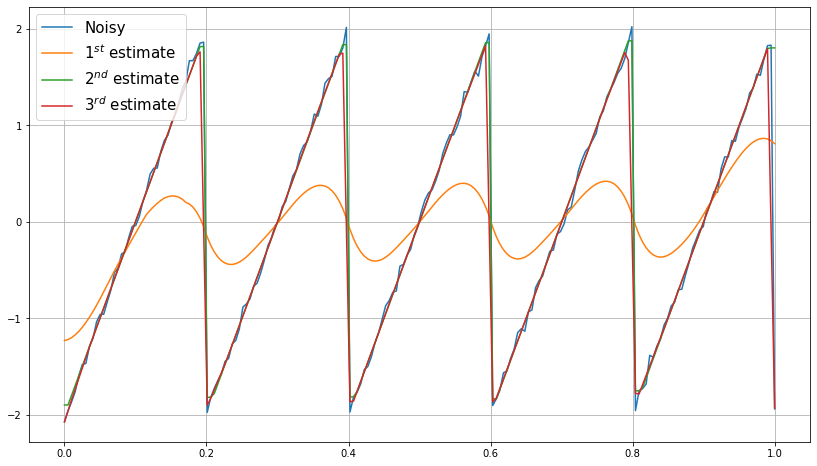

In [5]:
plt.figure(figsize=(14,8))
plt.plot(t, ySaw,label='Noisy')
plt.plot(t, estSaw1.x, label='$1^{st}$ estimate')
plt.plot(t, estSaw2.x, label='$2^{nd}$ estimate')
plt.plot(t, estSaw3.x, label='$3^{rd}$ estimate')
plt.grid(); plt.legend(fontsize=15)

We can see that the first estimate made with the penalty $||D_1 \hat{x}||_2$ fails to capture the high freq. components of the sawtooth, while the other 2 can capture them much better with the same weighting $\gamma$

In [6]:
# Quadratic estimate
estQ1 = sp.optimize.minimize(lambda y: obj1(y,xQuad,gamma[0]),yQuad)
estQ2 = sp.optimize.minimize(lambda y: obj2(y,xQuad,gamma[1]),yQuad)
estQ3 = sp.optimize.minimize(lambda y: obj3(y,xQuad,gamma[2]),yQuad)

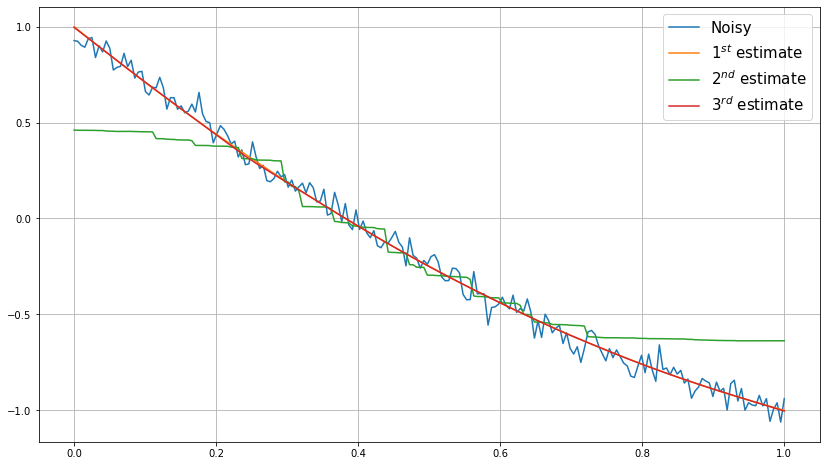

In [7]:
plt.figure(figsize=(14,8))
plt.plot(t, yQuad,label='Noisy')
plt.plot(t, estQ1.x, label='$1^{st}$ estimate')
plt.plot(t, estQ2.x, label='$2^{nd}$ estimate')
plt.plot(t, estQ3.x, label='$3^{rd}$ estimate')
plt.grid(); plt.legend(fontsize=15)

For the quadratic function above, now the 2\textsuperscript{nd} estimate of  $||D_1 \hat{x}_1||_1$ is the one that fails on the extremes, while the other 2 reconstruct the signal very well.

In [8]:
# PWM estimate
estPWM1 = sp.optimize.minimize(lambda y: obj1(y,xPWM,gamma[0]),yPWM)
estPWM2 = sp.optimize.minimize(lambda y: obj2(y,xPWM,gamma[1]),yPWM)
estPWM3 = sp.optimize.minimize(lambda y: obj3(y,xPWM,gamma[2]),yPWM)

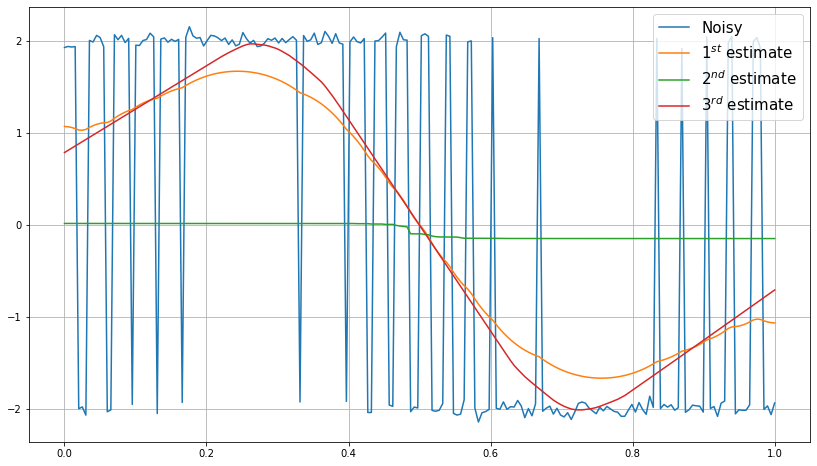

In [9]:
plt.figure(figsize=(14,8))
plt.plot(t, yPWM, label='Noisy')
plt.plot(t, estPWM1.x, label='$1^{st}$ estimate')
plt.plot(t, estPWM2.x, label='$2^{nd}$ estimate')
plt.plot(t, estPWM3.x, label='$3^{rd}$ estimate')
plt.grid(); plt.legend(fontsize=15)

For the PWM we see that depending on the norm we either capture the fundamental component of the carrier function (estimates 1 and 3) or we loose all of the information (estimate 2).
We could retune the $\gamma$ to either capture the carrier function or the true PWM function.

### 2. SDP and Schur complement
Rephrasing the problem we need to show that $a$ is a point inside the defined ellipsoid using the Schur complement. Hence it needs to hold the inequality:
\begin{equation}
(a-c)^T P^{-1}(a-c) \leq 1
\end{equation}
re-written as:
\begin{equation}
1-(a-c)^T P^{-1}(a-c) \geq 0
\end{equation}
Which is very similar to first matrix inequality stated in the problem. So:
\begin{equation}
C=1 \
B=(a-c) \
A=P
\end{equation}
Finally $X$ is given by:
\begin{equation}
    X=\begin{pmatrix}
    P & (a-c)^T\\
    a-c & 1
    \end{pmatrix}
\end{equation}
\begin{equation}
X \succ 0
\end{equation}

### 3. Goemans-Willamson relaxation
We need to solve:
\begin{equation}
\max x^T L x
\end{equation}
with $x_i^2-1=0$

In [10]:
n=20 # dimension

# Laplacian matrix
G = np.random.randint(0,5,n) * np.random.randint(0,5,n)[:, np.newaxis]
L = csgraph.laplacian(G, normed=False)

In [11]:
def graphFn(x,L):
    return x.T@L@x;

#### 3.1 Naive randomization

In [12]:
N=1000
cost=[]
for i in range(N):
    x = np.random.randint(-1,1,n)
    x[x==0] = 1
    cost.append(graphFn(x,L))

#### 3.2 SDP relaxation

#### 3.3 Goemans-Williamson approximation


#### 3.4 Mathematical Expectation
We now add the mean of all the slices calculated as:
\begin{equation}
\mathbb{E}=\frac{1}{N}\sum_{i=1}^{N} x_i^T L x_i
\end{equation}

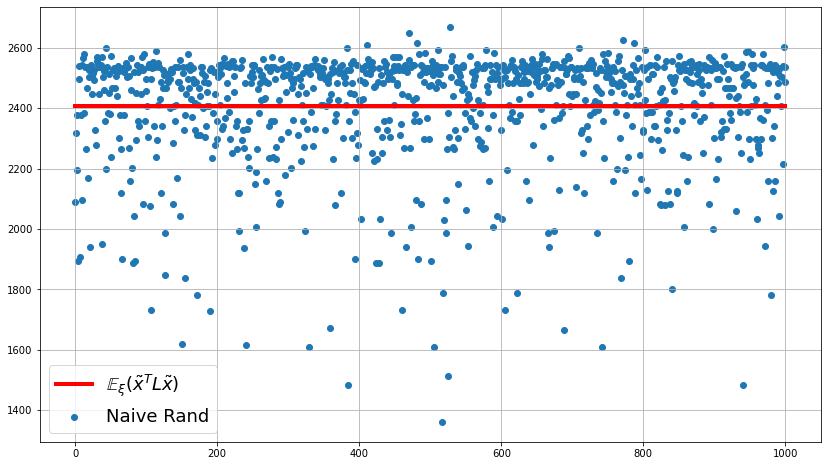

In [13]:
meanFun=np.mean(cost)

plt.figure(figsize=(14,8))
plt.scatter(np.linspace(0,N,N),cost,label='Naive Rand')
plt.plot(np.linspace(0,N,N),meanFun*np.ones(N),color='red',linewidth=4,label=r'$\mathbb{E}_{\xi} ( \tilde{x}^T L \tilde{x})$')
plt.grid(); plt.legend(fontsize=18);

### 4. Linear Programming
#### 4.1. Formulation
A cargo plane has three compartments for storing cargo: front, center, and back. Details of weight and
volume capacities are given in the task statement.

##### Variables
The decision variables allow us to determine how much of each of the four cargoes to place in each of the
three compartments.

Thus, the variable $x_{ij}$ is the number of tons of cargo $i$ to be placed in compartment $j$
where $i = 1; 2; 3; 4$ for $C1$, $C2$, $C3$ and $C4$ respectively. The subscripts are $j = 1$ for the front one, $j = 2$ for the central one and $j = 3$ for the rear one.

Furthermore $x_{ij} >= 0$. 

Since we are explicitly told that we can divide the loads in any proportions (fractions) we want.

##### Constraints
For the rows:
\begin{equation}
 \sum_{i=1}^{3} x_{1,i}   \leq 18
\end{equation}
\begin{equation}
 \sum_{i=1}^{3} x_{2,i}   \leq 15
\end{equation}
\begin{equation}
 \sum_{i=1}^{3} x_{3,i}   \leq 23
\end{equation}
\begin{equation}
 \sum_{i=1}^{3} x_{4,i}   \leq 12
\end{equation}

For the columns:
\begin{equation}
 \sum_{i=1}^{4} x_{i,1}   \leq 10
\end{equation}
\begin{equation}
 \sum_{i=1}^{4} x_{i,2}   \leq 16
\end{equation}
\begin{equation}
 \sum_{i=1}^{4} x_{i,3}   \leq 8
\end{equation}

For the whole matrix:
\begin{equation}
    x.\begin{pmatrix}
    480 \\ 
    650 \\ 
    580 \\ 
    390 \\
    \end{pmatrix} \leq
    \begin{pmatrix}
    6800 \\ 
    8700 \\ 
    5300 \\
    \end{pmatrix}
\end{equation}

Between columns:
\begin{equation}
16 \sum_{i=1}^{4} x_{i,1}= 10 \sum_{i=1}^{4} x_{i,2}
\end{equation}
\begin{equation}
8 \sum_{i=1}^{4} x_{i,2}= 16 \sum_{i=1}^{4} x_{i,3}
\end{equation}

##### Objective function $J$
\begin{equation}
    \max \begin{pmatrix}
            310 & 380 & 350 & 285
            \end{pmatrix} x.\begin{pmatrix}
            1 \\
            1 \\
            1 \\
            \end{pmatrix}
\end{equation}

#### 4.2 Assumptions
- Every cargo can be divided into any proportions/fractions we wish
- Every cargo can be divided into two or more compartments if desired
- Every cargo can be packed in each compartment

#### 4.3 Solution

In [15]:
# Cost function
costMat = np.array([-310.0,-310.0,-310.0,
              -380.0,-380.0,-380.0,
              -350.0, -350.0, -350.0,
              -285.0, -285.0, -285.0])
# Upper bounds
Aub = np.array([[1.0, 1.0, 1.0, 0.0,0,0,0,0,0,0,0,0],
                 [0,0,0,1,1,1,0,0,0,0,0,0],
                 [0,0,0,0,0,0,1,1,1,0,0,0],
                 [0,0, 0,0,0,0,0,0,0,1,1,1],
                 [1,0,0,1,0,0,1,0,0,1,0,0],
                 [0,1,0,0,1,0,0,1,0,0,1,0],
                 [0,0,1,0,0,1,0,0,1,0,0,1],
                 [480,0,0,650,0,0,580,0,0,390,0,0],
                 [0,480,0,0,650,0,0,580,0,0,390,0],
                 [0,0,480,0,0,650,0,0,580,0,0,390]])

Bub = np.array([18.0, 15.0, 23, 12, 10, 16, 8, 6800, 8700, 5300])

# Equality constraints
Aeq = np.array([[0, 1, -2, 0, 1,-2,0,1,-2,0,1,-2],
                 [-8, 5, 0, -8, 5,0,-8,5,0,-8,5,0]])
Beq = np.array([0.0, 0.0])

xBounds = []
for i in range(12):
    xBounds.append((0, None))

result = sp.optimize.linprog(costMat, A_ub=Aub, b_ub=Bub, A_eq=Aeq, b_eq=Beq, bounds=xBounds)
print(result)

     con: array([9.24877952e-11, 2.01597465e-10])
     fun: -12151.578947183178
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([1.80000000e+01, 2.73331580e-10, 7.05263158e+00, 8.94736842e+00,
       1.31304745e-10, 2.50404142e-10, 7.89590615e-11, 3.92237180e+02,
       1.53308065e-07, 2.17762820e+02])
  status: 0
 success: True
       x: array([5.67594793e-11, 8.99903905e-11, 5.30726735e-11, 8.68232600e+00,
       9.14023531e-11, 6.31767400e+00, 1.31767400e+00, 1.29473684e+01,
       1.68232600e+00, 5.54182248e-11, 3.05263158e+00, 3.60493497e-11])


In [16]:
# Optimal cost
xOpt=result.x
costOpt=costMat@xOpt
print(costOpt)

-12151.578947183178


The optimal cost.

We will now run a sensitivity analysis for the available weights constraint. For an increase in availability of 10\% the objective function increases to \\$12875.63 which represents an increase of 5.95 \%. For a decrease in availability of 10\% the optimal value changes to \\$11160.0 which represents a decrease in profit of 8.16\%.
Additionally, we can conclude that the greatest influence is had by charges C2 and C3 because they have the highest probability associated with them.